# **Toxic Comments Classification**

In [9]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.layers import Embedding,GlobalAvgPool1D,Dense,Dropout,Bidirectional,LSTM,GRU

**Import Data**

In [36]:
# load dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [11]:
print(train.shape)
print(test.shape)

(159571, 8)
(153164, 2)


In [12]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [13]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [14]:
# example of test toxic comments
test['comment_text'][55]

'":I see that you moved  to Talat Hamdani. Perhaps you had not read the MfD notice on the page, which says ""please do not blank, merge, or move it, or remove this notice, while the discussion is in progress"". (My emphasis.)    \n\n "'

In [15]:
# example of toxic comments
train.loc[train['toxic'] == 1][:3]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0


In [16]:
comment = train['comment_text'][12]
comment

'Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...'

In [17]:
# drop row that has Null or empty comment
train = train.dropna(subset=['comment_text'])

In [18]:
label = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
len(label)

6

**Plotting Data**

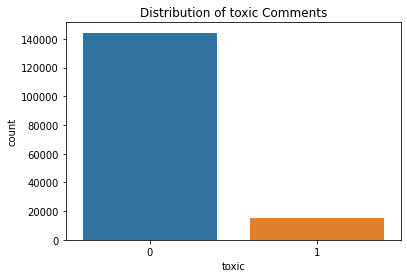

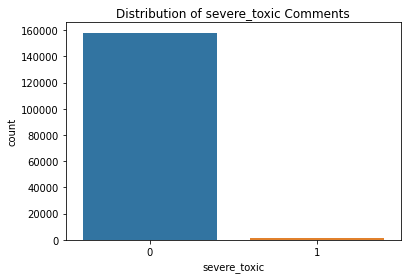

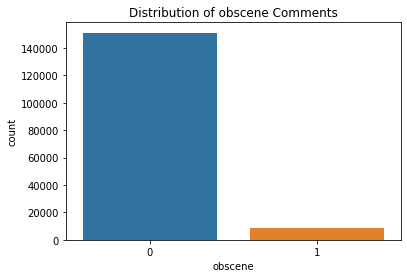

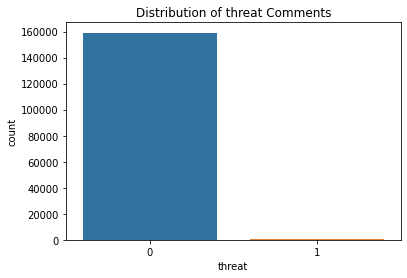

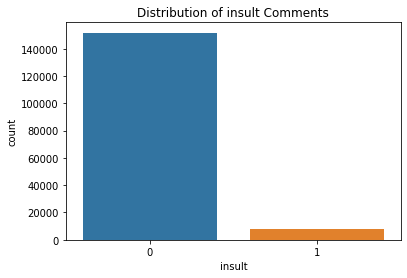

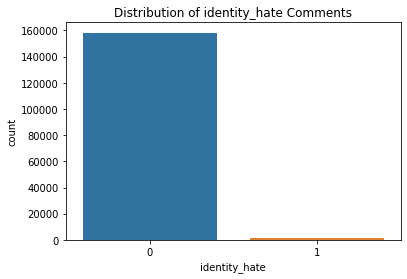

In [19]:
# plot 
import seaborn as sns
k = 0
for i in range(6):
  y = train[label[k]].values
  sns.countplot(x='{}'.format(label[k]), data=train)
  plt.title('Distribution of {} Comments'.format(label[k]))
  plt.show()
  k += 1
  

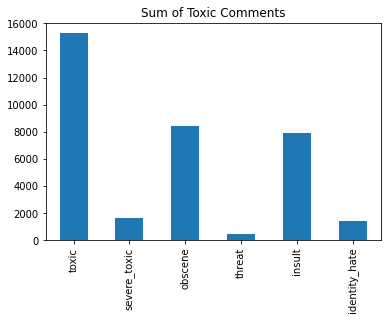

In [20]:
train_labels = train[label]
train_labels.sum(axis=0).plot.bar(title="Sum of Toxic Comments")

**Preprocessing Data**

In [21]:
# download the stopwords from NLTK
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [37]:
# cleaning comment using regex
import re

def cleaning_text(comment):
  comment = comment.lower()
  comment = re.sub('[/(){}\[\]\|@,;]', ' ', comment)
  comment = re.sub('[^0-9a-z ]', '', comment)
  comment = re.sub(r'\s+', ' ', comment)
  comment = re.sub(r'\n', ' ', comment)
  return comment

In [38]:
# apply the regex to all of the words
train['comment_text'] = train['comment_text'].apply(lambda x: cleaning_text(x))

In [39]:
train['comment_text'][12]

'hey what is it talk what is it an exclusive group of some wp talibanswho are good at destroying selfappointed purist who gang up any one who asks them questions abt their antisocial and destructive non contribution at wpask sityush to clean up his behavior than issue me nonsensical warnings'

In [40]:
vocab_size = 10000
embedding_dim = 16
max_length = 200
trunc_type='post'
padding_type='post'

In [41]:
# divide data into train and test
training_sentences = train['comment_text']
testing_sentences = test['comment_text']
training_labels = train_labels.values
# testing_labels = labels[training_size:]

In [26]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [28]:
# change into array for cnn
import numpy as np

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)

**Building Model**

In [43]:
# building the CNN model
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(vocab_size, 128, input_length=max_length),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.Conv1D(64, activation='relu', kernel_size=2),
  tf.keras.layers.GlobalMaxPool1D(),
  # tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(6, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer="RMSprop", metrics=["accuracy"])

In [44]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 128)          1280000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 200, 128)          131584    
_________________________________________________________________
conv1d (Conv1D)              (None, 199, 64)           16448     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                

In [46]:
batch_size = 64
epoch = 5

history = model.fit(training_padded, training_labels, batch_size, epochs=epoch, validation_split=0.2, verbose=2)

Epoch 1/5
250/250 - 133s - loss: 0.2370 - accuracy: 0.6357 - val_loss: 0.1579 - val_accuracy: 0.9937
Epoch 2/5
250/250 - 129s - loss: 0.1683 - accuracy: 0.6939 - val_loss: 0.1557 - val_accuracy: 0.9937
Epoch 3/5
250/250 - 127s - loss: 0.1560 - accuracy: 0.8844 - val_loss: 0.1578 - val_accuracy: 0.9937
Epoch 4/5
250/250 - 128s - loss: 0.1464 - accuracy: 0.9858 - val_loss: 0.1704 - val_accuracy: 0.9937
Epoch 5/5
250/250 - 129s - loss: 0.1396 - accuracy: 0.9916 - val_loss: 0.1698 - val_accuracy: 0.9937


**Plotting Accuracy and Loss for train and test data**

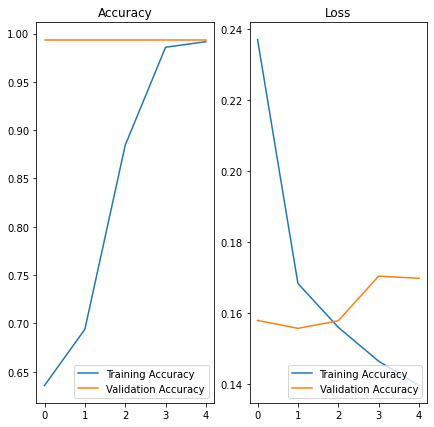

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(7,7))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Accuracy')
plt.plot(epochs_range, val_loss, label='Validation Accuracy')
plt.title('Loss')
plt.legend(loc='lower right')
plt.show()

**Prediction using the model**

In [65]:
def predict(comment):
  sequences = tokenizer.texts_to_sequences(comment)
  padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
  predictions = model.predict(padded)
  print(comment)
  print('\n')
  for i in range(5):
    print('Probability {} = {}'.format(label[i], predictions[0][i]))

In [68]:
comment_1 = ["stop writting stuffs.. you are scarring off all the gentlemen!"]
comment_2 = ["you should be fired youre a moronic wimp who is too lazy to do research it makes me sick that people like you exist in this world"]

prediction_1 = predict(comment_1)
print("------------------------------------------------------------------------------------------------------------------------------------------------")
prediction_2 = predict(comment_2)

['stop writting stuffs.. you are scarring off all the gentlemen!']


Probability toxic = 0.0725984275341034
Probability severe_toxic = 0.0022853612899780273
Probability obscene = 0.03236740827560425
Probability threat = 0.0002060234546661377
Probability insult = 0.026404738426208496
------------------------------------------------------------------------------------------------------------------------------------------------
['you should be fired youre a moronic wimp who is too lazy to do research it makes me sick that people like you exist in this world']


Probability toxic = 0.11882662773132324
Probability severe_toxic = 0.004581570625305176
Probability obscene = 0.05978694558143616
Probability threat = 0.000521928071975708
Probability insult = 0.04699438810348511
